In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!pip install -q kaggle opendatasets

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
from pathlib import Path
import time
from collections import defaultdict
from typing import Tuple, List, Dict, Any
import os
import json

In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Device: cuda
GPU: Tesla T4
Memory: 15.64 GB


In [9]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/emmarex/plantdisease')

DATA_DIR = './plantdisease/PlantVillage'

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease


100%|██████████| 658M/658M [00:03<00:00, 181MB/s]

In [10]:
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 0.0001
IMG_SIZE = 224
NUM_WORKERS = 2
SUBSET_RATIO = 0.2

In [11]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
def load_data(data_dir: str, train_split: float = 0.8, subset_ratio: float = 0.2) -> Tuple[DataLoader, DataLoader, List[str]]:
    full_dataset = datasets.ImageFolder(data_dir)

    subset_size = int(len(full_dataset) * subset_ratio)
    indices = np.random.choice(len(full_dataset), subset_size, replace=False)
    subset_dataset = Subset(full_dataset, indices)

    train_size = int(train_split * len(subset_dataset))
    val_size = len(subset_dataset) - train_size

    train_dataset, val_dataset = random_split(
        subset_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    class WrappedDataset:
        def __init__(self, subset, transform):
            self.subset = subset
            self.transform = transform

        def __getitem__(self, idx):
            img, label = self.subset[idx]
            if not isinstance(img, torch.Tensor):
                img = self.transform(img)
            return img, label

        def __len__(self):
            return len(self.subset)

    train_wrapped = WrappedDataset(train_dataset, train_transforms)
    val_wrapped = WrappedDataset(val_dataset, val_transforms)

    train_loader = DataLoader(
        train_wrapped,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_wrapped,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    class_names = full_dataset.classes

    print(f"Full dataset: {len(full_dataset)}")
    print(f"Subset ({int(subset_ratio*100)}%): {len(subset_dataset)}")
    print(f"Train: {train_size}")
    print(f"Val: {val_size}")
    print(f"Classes: {len(class_names)}")

    return train_loader, val_loader, class_names

In [13]:
train_loader, val_loader, class_names = load_data(DATA_DIR, subset_ratio=SUBSET_RATIO)
num_classes = len(class_names)

with open('class_names.json', 'w') as f:
    json.dump(class_names, f, indent=2)

Full dataset: 20638
Subset (20%): 4127
Train: 3301
Val: 826
Classes: 15


In [14]:
def create_model(num_classes: int) -> nn.Module:
    model = models.efficientnet_b0(weights='IMAGENET1K_V1')
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    return model.to(DEVICE)

In [15]:
model = create_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 227MB/s]


In [16]:
def train_epoch(model: nn.Module, dataloader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer, epoch: int) -> Tuple[float, float]:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (batch_idx + 1) % 10 == 0:
            print(f"  [{batch_idx+1}/{len(dataloader)}] Loss: {loss.item():.4f} Acc: {100*correct/total:.2f}%", end='\r')

    print()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [17]:
def validate(model: nn.Module, dataloader: DataLoader, criterion: nn.Module) -> Tuple[float, float, List[int], List[int]]:
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [18]:
def calculate_per_class_accuracy(labels: List[int], preds: List[int], class_names: List[str]) -> Dict[str, float]:
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    for label, pred in zip(labels, preds):
        class_total[label] += 1
        if label == pred:
            class_correct[label] += 1

    per_class_acc = {}
    for class_idx in range(len(class_names)):
        if class_total[class_idx] > 0:
            acc = 100 * class_correct[class_idx] / class_total[class_idx]
            per_class_acc[class_names[class_idx]] = acc
        else:
            per_class_acc[class_names[class_idx]] = 0.0

    return per_class_acc

In [19]:
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0
patience = 5
patience_counter = 0

print("="*70)
print("TRAINING START")
print("="*70)

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch)
    val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion)

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    epoch_time = time.time() - start_time

    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}   | Val Acc: {val_acc:.2f}%")
    print(f"  LR: {current_lr:.6f} | Time: {epoch_time:.2f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_names': class_names
        }, 'best_model.pth')
        print(f"  Best model saved (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"\n  Early stopping at epoch {epoch+1}")
        break

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)

TRAINING START

Epoch 1/15
----------------------------------------------------------------------

  Train Loss: 1.9046 | Train Acc: 50.32%
  Val Loss: 0.9425   | Val Acc: 77.85%
  LR: 0.000099 | Time: 36.13s
  Best model saved (Val Acc: 77.85%)

Epoch 2/15
----------------------------------------------------------------------

  Train Loss: 0.7468 | Train Acc: 79.67%
  Val Loss: 0.3589   | Val Acc: 89.83%
  LR: 0.000096 | Time: 35.84s
  Best model saved (Val Acc: 89.83%)

Epoch 3/15
----------------------------------------------------------------------

  Train Loss: 0.4175 | Train Acc: 87.55%
  Val Loss: 0.2176   | Val Acc: 94.07%
  LR: 0.000090 | Time: 29.38s
  Best model saved (Val Acc: 94.07%)

Epoch 4/15
----------------------------------------------------------------------

  Train Loss: 0.3090 | Train Acc: 90.82%
  Val Loss: 0.1455   | Val Acc: 96.00%
  LR: 0.000083 | Time: 29.93s
  Best model saved (Val Acc: 96.00%)

Epoch 5/15
-------------------------------------------------

In [20]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
_, _, final_preds, final_labels = validate(model, val_loader, criterion)

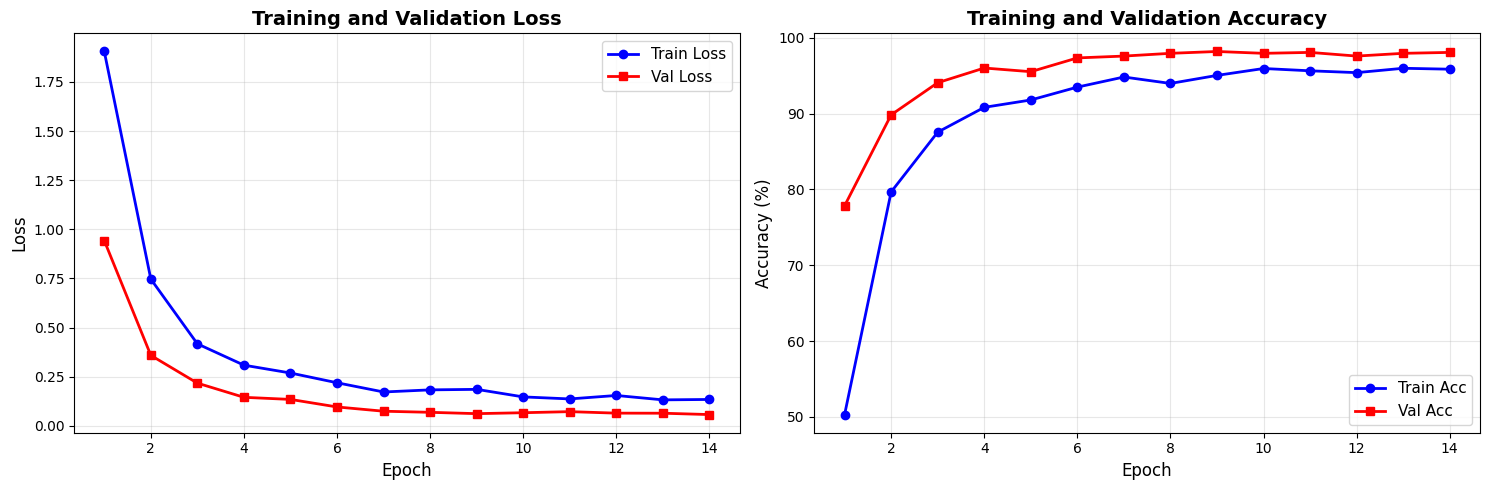

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(history['train_loss']) + 1)

ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
ax1.plot(epochs, history['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, history['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=6)
ax2.plot(epochs, history['val_acc'], 'r-s', label='Val Acc', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
per_class_acc = calculate_per_class_accuracy(final_labels, final_preds, class_names)

print("\n" + "="*70)
print("PER-CLASS ACCURACY")
print("="*70)
for class_name, acc in sorted(per_class_acc.items(), key=lambda x: x[1], reverse=True):
    print(f"  {class_name:40s}: {acc:6.2f}%")


PER-CLASS ACCURACY
  Pepper__bell___Bacterial_spot           : 100.00%
  Pepper__bell___healthy                  : 100.00%
  Potato___Early_blight                   : 100.00%
  Potato___healthy                        : 100.00%
  Tomato__Target_Spot                     : 100.00%
  Tomato__Tomato_mosaic_virus             : 100.00%
  Tomato_healthy                          : 100.00%
  Tomato__Tomato_YellowLeaf__Curl_Virus   :  99.25%
  Tomato_Septoria_leaf_spot               :  98.31%
  Tomato_Bacterial_spot                   :  97.89%
  Tomato_Spider_mites_Two_spotted_spider_mite:  97.10%
  Tomato_Leaf_Mold                        :  96.97%
  Tomato_Late_blight                      :  96.74%
  Potato___Late_blight                    :  93.33%
  Tomato_Early_blight                     :  93.33%


In [23]:
f1_macro = f1_score(final_labels, final_preds, average='macro')
f1_weighted = f1_score(final_labels, final_preds, average='weighted')

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(f"\nF1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}\n")
print(classification_report(final_labels, final_preds, target_names=class_names, digits=4))


CLASSIFICATION REPORT

F1 Score (Macro): 0.9765
F1 Score (Weighted): 0.9819

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot     1.0000    1.0000    1.0000        24
                     Pepper__bell___healthy     1.0000    1.0000    1.0000        44
                      Potato___Early_blight     1.0000    1.0000    1.0000        49
                       Potato___Late_blight     0.9767    0.9333    0.9545        45
                           Potato___healthy     0.8333    1.0000    0.9091         5
                      Tomato_Bacterial_spot     0.9688    0.9789    0.9738        95
                        Tomato_Early_blight     0.9655    0.9333    0.9492        30
                         Tomato_Late_blight     0.9570    0.9674    0.9622        92
                           Tomato_Leaf_Mold     1.0000    0.9697    0.9846        33
                  Tomato_Septoria_leaf_spot     0.9831    0.9831    0.9

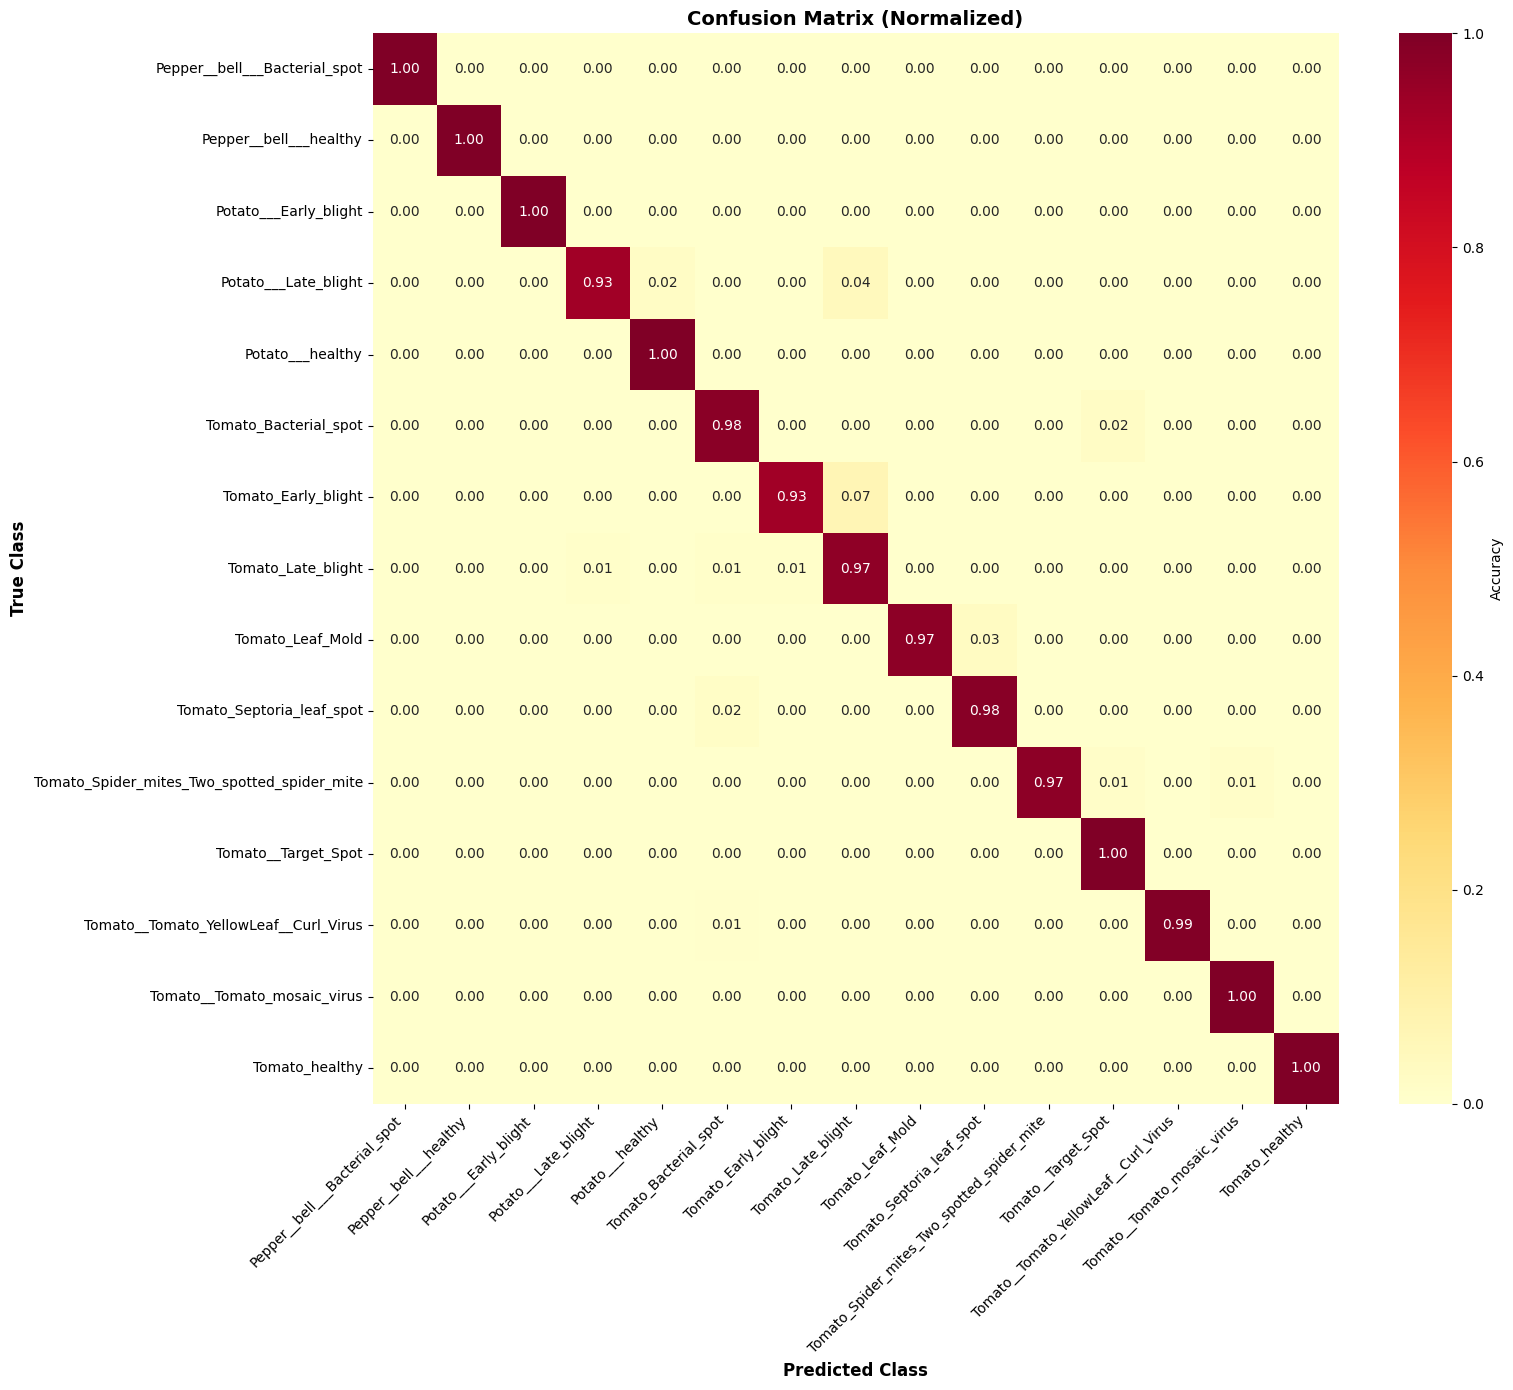

In [24]:
cm = confusion_matrix(final_labels, final_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 14))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Accuracy'},
    vmin=0,
    vmax=1
)

plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
plt.ylabel('True Class', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

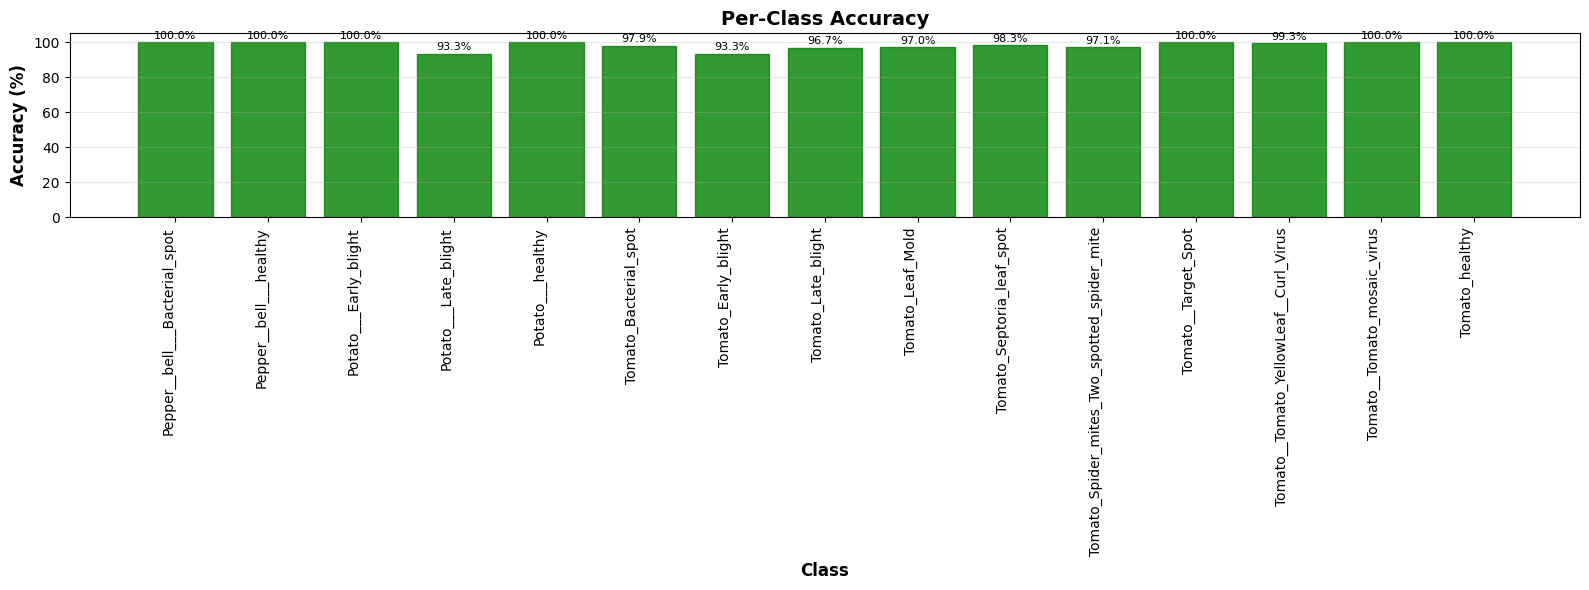

In [25]:
classes = list(per_class_acc.keys())
accuracies = list(per_class_acc.values())

plt.figure(figsize=(16, 6))
bars = plt.bar(range(len(classes)), accuracies, color='steelblue', alpha=0.8)

for bar, acc in zip(bars, accuracies):
    if acc >= 90:
        bar.set_color('green')
    elif acc >= 70:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.xlabel('Class', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xticks(range(len(classes)), classes, rotation=90, ha='right')
plt.ylim(0, 105)
plt.grid(axis='y', alpha=0.3)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 2, f'{acc:.1f}%', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

In [26]:
print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")
print(f"\nModel: best_model.pth")
print(f"Class names: class_names.json")
print(f"\nDownload from Files sidebar (left)")


Best Validation Accuracy: 98.18%
F1 Score (Macro): 0.9765
F1 Score (Weighted): 0.9819

Model: best_model.pth
Class names: class_names.json

Download from Files sidebar (left)


## Inference

In [27]:
from google.colab import files

uploaded = files.upload()

Saving 5c532630-a204-4e10-8fb4-5a0d09f9a1eb___JR_B.Spot 3214.JPG to 5c532630-a204-4e10-8fb4-5a0d09f9a1eb___JR_B.Spot 3214.JPG


In [28]:
def predict_image(model: nn.Module, image_path: str, class_names: List[str]) -> Dict[str, Any]:
    from PIL import Image

    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    pred_class = predicted.item()
    conf_score = confidence.item()

    top5_prob, top5_idx = torch.topk(probabilities, k=min(5, len(class_names)), dim=1)

    result = {
        'predicted_class': class_names[pred_class],
        'confidence': conf_score,
        'top5': [(class_names[top5_idx[0][i].item()], top5_prob[0][i].item()) for i in range(top5_prob.size(1))]
    }

    return result

for filename in uploaded.keys():
    result = predict_image(model, filename, class_names)
    print(f"\nImage: {filename}")
    print(f"Predicted: {result['predicted_class']} ({result['confidence']*100:.2f}%)")
    print(f"Top 5:")
    for cls, prob in result['top5']:
        print(f"  {cls}: {prob*100:.2f}%")


Image: 5c532630-a204-4e10-8fb4-5a0d09f9a1eb___JR_B.Spot 3214.JPG
Predicted: Pepper__bell___Bacterial_spot (99.58%)
Top 5:
  Pepper__bell___Bacterial_spot: 99.58%
  Pepper__bell___healthy: 0.19%
  Potato___Early_blight: 0.10%
  Tomato_Early_blight: 0.04%
  Tomato_Septoria_leaf_spot: 0.02%
